# Transformer


Transformer 모델은 자연어 처리와 같은 시퀀스 데이터를 처리하는 데 혁신적인 방법을 제시한 딥러닝 모델이다. 기존 RNN 기반 모델의 한계를 극복하고 효율성과 성능을 크게 향상시킨 모델로, "Attention is All You Need" 논문(2017)에서 처음 소개되었다.

<table>
<tr>
  <th colspan=1>The original Transformer diagram</th>
  <th colspan=1>A representation of a 4-layer Transformer</th>
</tr>
<tr>
  <td>
   <img width=400 src="https://www.tensorflow.org/images/tutorials/transformer/transformer.png"/>
  </td>
  <td>
   <img width=307 src="https://www.tensorflow.org/images/tutorials/transformer/Transformer-4layer-compact.png"/>
  </td>
</tr>
</table>

<br/>

<img src="https://www.tensorflow.org/images/tutorials/transformer/apply_the_transformer_to_machine_translation.gif" alt="Applying the Transformer to machine translation">

![https://www.tensorflow.org/text/tutorials/transformer#scaled_dot_product_attention](https://d.pr/i/O6WlEu+)

https://www.tensorflow.org/text/tutorials/transformer#scaled_dot_product_attention




**Transformer 모델의 주요 구성 요소**
Transformer는 크게 두 가지 블록으로 구성된다: **인코더(Encoder)**와 **디코더(Decoder)**. 인코더는 입력 시퀀스를 처리하고, 디코더는 이를 기반으로 출력 시퀀스를 생성한다.

1. **Self-Attention Mechanism**
   - 입력 데이터 내의 각 단어가 다른 단어와 어떤 관계를 가지는지 학습하는 메커니즘이다.
   - 단어 간 상관관계를 효율적으로 계산하며, 이를 통해 문맥 정보를 반영한다.
   - 핵심 구성 요소:
     - **Query (Q)**: 현재 단어의 정보
     - **Key (K)**: 비교 대상 단어의 정보
     - **Value (V)**: 실제 반환될 정보
     $$ Attention(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V $$

2. **Multi-Head Attention**
   - Self-Attention을 여러 개의 서로 다른 공간에서 병렬적으로 계산하여 다양한 문맥 정보를 학습한다.
   - 각 헤드에서 서로 다른 부분의 관계를 포착하고 이를 결합한다.

3. **Feed-Forward Neural Network**
   - 각 단어 위치별로 독립적으로 처리하는 완전연결층.
   - 비선형성을 추가하여 모델의 표현력을 높인다.

4. **Positional Encoding**
   - Transformer는 RNN처럼 순차적인 정보 흐름을 따르지 않으므로, 단어의 위치 정보를 추가적으로 학습해야 한다.
   - 이를 위해 각 단어에 고유한 위치 정보를 더하는 Positional Encoding을 사용한다.
   - 일반적으로 사인(sin)과 코사인(cos) 함수를 이용해 계산된다.

5. **Residual Connection**
   - 학습이 더 잘 이루어지도록, 각 층의 입력을 출력에 더하는 연결을 사용한다.
   - 이로 인해 모델이 더 깊어져도 학습이 안정적으로 진행된다.

6. **Layer Normalization**
   - 각 층의 출력을 정규화하여 학습 속도를 높이고 안정성을 확보한다.

## 1. Transformer Hyperparameter

 트랜스포머를 제안한 논문에서 사용한 수치로 하이퍼파라미터는 사용자가 모델 설계시 임의로 변경할 수 있는 값들이다.

- **$d_{model} = 512$**

  $d_{model}$은 트랜스포머의 인코더와 디코더에서 입력과 출력의 크기를 의미한다. 또한, 임베딩 벡터의 차원 역시 $d_{model}$이며, 각 인코더와 디코더가 다음 층으로 값을 전달할 때도 이 차원을 유지한다. 논문에서는 $d_{model}$을 512로 설정하였다.

- **$num\_layers = 6$**

  $num\_layers$는 트랜스포머에서 인코더와 디코더가 각각 몇 층으로 구성되었는지를 나타낸다. 하나의 인코더 또는 디코더를 하나의 층으로 간주하며, 논문에서는 인코더와 디코더를 각각 6층으로 쌓았다.

- **$num\_heads = 8$**

  $num\_heads$는 트랜스포머에서 멀티 헤드 어텐션의 병렬 개수를 의미한다. 트랜스포머는 어텐션을 한 번 수행하는 대신 여러 개로 분할하여 병렬로 수행한 뒤, 결과값을 다시 하나로 합친다. 논문에서는 $num\_heads$를 8로 설정하였다.

- **$d_{ff} = 2048$**

  $d_{ff}$는 트랜스포머 내부 피드 포워드 신경망의 은닉층 크기를 의미한다. 피드 포워드 신경망의 입력층과 출력층 크기는 $d_{model}$과 동일하며, 논문에서는 은닉층 크기를 2048로 설정하였다.

- **$dropout = 0.1$**

  $dropout$은 드롭아웃을 적용할 확률을 나타낸다. 트랜스포머 모델에서 드롭아웃을 사용하였으며, 논문에서는 드롭아웃 비율을 0.1로 설정하였다.


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

d_model = 512              # 모델 임베딩 차원
num_layers = 6             # Encoder/Decoder 블록(레이어) 수
num_heads = 8              # 8 Multi-Head Attention
d_k = d_model // num_heads # 분할된 Q,K,V 차원수(512/8 = 64)
d_ff = 2048                # Position-wise FFN의 은닉 차원
drop_out_rate = 0.1        # Dropout 비율 (과적합 완화)

# 원문 사전 크기
src_vocab_size = 10000
# 번역문 사전 크기
trg_vocab_size = 10000

batch_size = 64             # 배치 크기
seq_len = 128               # 최대 시퀀스 길이(패딩/마스킹)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


## Transformer 구성요소

In [ ]:
# Transformer 모델 뼈대 정의(Embedding -> Encoder -> Decoder -> Output)
# 토큰 임베딩에 위치 정보(순서)를 더해주는 Positional Ecoding 모듈(차후 구현)
class PositionalEncoding(nn.Module):
    pass

# 소스 입력을 인코딩해 문맥 표현(encoder output)을 만드는 Encoder 모듈
class Encoder(nn.Module):
    pass

# 타겟 입력과 encoder outputs을 이용해 디코딩 출력 시퀀스를 만드는 Decoder 모듈 
class Decoder(nn.Module):
    pass

# Transformer (임베딩+포지셔널 -> 인코더 -> 디코더 -> 출력층)
class Transformer(nn.Module):
    def __init__(self, src_vocab_size, trg_vocab_size, d_model):
        super().__init__()                                              # nn.Module 초기화
        self.src_embedding = nn.Embedding(src_vocab_size, d_model)      # 소스(원문) 토큰 ID -> 임베딩(d_model)
        self.trg_embedding = nn.Embedding(trg_vocab_size, d_model)      # 타겟(번역문) 토큰 ID -> 임베딩(d_model)
        self.positional_encoding = PositionalEncoding()                 # 위치정보 인코딩 모듈
        self.encoder = Encoder()                                        # 인코더
        self.decoder = Decoder()                                        # 디코더 
        self.output_layer = nn.Linear(d_model, trg_vocab_size)          # 출력층(d_model) -> 어휘 로짓(vocab)
        self.softmax = nn.LogSoftmax(dim=-1)                            # 마지막 차원 기준은 로그확률로 변환

    def forward(self, src_inputs, trg_inputs, e_mask=None, d_mask=None):
        # 1.embedding + positional encoding
        src_inputs = self.src_embedding(src_inputs)         # (B, T_src) -> (B, T_src, d_model)
        src_inputs = self.positional_encoding(src_inputs)   # 위치 정보 추가
        trg_inputs = self.trg_embedding(trg_inputs)         # (B, T_trg) -> (B, T_trg, d_model)
        trg_inputs = self.positional_encoding(trg_inputs)   # 위치 정보 추가

        # 2. encoder : 소스 문장 인코딩 결과 생성
        encoder_outputs = self.encoder(src_inputs, e_mask) 

        # 3. decoder : 디코딩 출력 생성
        decoder_outputs = self.decoder(trg_inputs, encoder_outputs, e_mask, d_mask)

        # 4. output layer : 출력층 생성
        outputs = self.output_layer(decoder_outputs)    # (B, T_trg, d_model) -> (B, T_trg, trg_vocab_size)
        outputs = self.softmax(outputs)                 # 각 시점별 타겟 토큰 로그확률 분포
        return outputs                                  # 최종 로그확률 반환

### PositionalEncoding

인코더와 디코더에 대한 입력은 동일한 임베딩 및 위치 인코딩 logic을 사용한다.

<table>
<tr>
  <th colspan=1>The embedding and positional encoding layer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/PositionalEmbedding.png"/>
  </td>
</tr>
</table>

일련의 토큰이 주어지면 입력 토큰(포르투갈어)과 대상 토큰(영어)을 `nn.Embedding` 레이어를 사용하여 벡터로 변환해야 한다.

모델 전체에서 사용되는 Attention 레이어는 입력을 순서가 없는 벡터 집합으로 간주한다. 모델에는 순환 레이어나 컨벌루션 레이어가 포함되어 있지 않기 때문에 단어 순서를 식별할 수 있는 방법이 필요하다.

Transformer는 임베딩 벡터에 "위치 인코딩"을 추가한다. 위치 인코딩은 서로 다른 주파수의 사인과 코사인 세트를 사용하여 시퀀스 전반에 걸쳐 위치 정보를 부여해서 단어의 상대적인 위치 정보를 지정할 수 있다.

논문에서는 위치 인코딩을 계산하기 위해 다음 공식을 사용하였다.

$$\Large{PE_{(pos, 2i)} = \sin(pos / 10000^{2i / d_{model}})} $$
$$\Large{PE_{(pos, 2i+1)} = \cos(pos / 10000^{2i / d_{model}})} $$

In [ ]:
import math

class PositionalEncoding(nn.Module):
    def __init__(self, seq_len, d_model):
        super().__init__()

        pos_encoding = torch.zeros(seq_len, d_model)

        for pos in range(seq_len):
            for i in range(d_model):
                if i % 2 == 0:
                    pos_encoding[pos, i] = math.sin(pos / (10000 ** (2 * i / d_model)))
                else:
                    pos_encoding[pos, i] = math.cos(pos / (10000 ** (2 * i / d_model)))

        pos_encoding = pos_encoding.unsqueeze(0)    

        self.pos_encoding = pos_encoding.to(device).requires_grad_(False)

    def forward(self, x):
        x = x * math.sqrt(d_model) # 임베팅과 위치인코딩을 비슷한 스케일로 처리
        x = x + self.pos_encoding # (batch_size, seq_len, d_model)
        return x


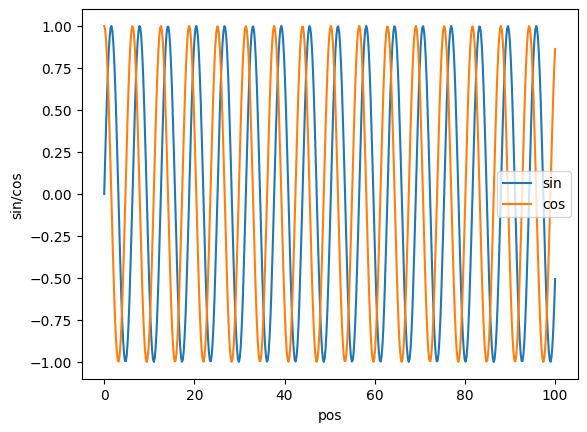

In [ ]:
# cos/sin 정현파 시각화 (확인용)
import numpy as np
import matplotlib.pyplot as plt

pos = np.linspace(0, 100, 500)      # 위치(pos) 값을 0~100 구간에서 500개 샘플 생성
d_model = 512                       # 모델 차원
i = 0 # 임의의 차원                  # 임의의 차원

sin_wave = np.sin(pos / (10000 ** (2 * i / d_model)))
cos_wave = np.cos(pos / (10000 ** (2 * i / d_model)))

plt.plot(pos, sin_wave, label='sin')
plt.plot(pos, cos_wave, label='cos')

plt.xlabel('pos')
plt.ylabel('sin/cos')
plt.legend()
plt.show()


### Position-wise Feed-Forward Network

인코더와 디코더의 각 서브-레이어(sub-layer)에는 Multi-Head Attention 이후에 Position-wise Feed-Forward Network가 적용됩니다. 이는 두 개의 선형 변환과 ReLU 활성화 함수로 구성된 간단한 신경망입니다. 각 단어의 위치(position)마다 독립적으로 동일한 연산을 적용합니다.

<table>
<tr>
  <th colspan=1>The feed forward network</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/FeedForward.png"/>
  </td>
</tr>
</table>

네트워크는 중간에 ReLU 활성화가 있는 두 개의 선형 레이어(`nn.Linear`)와 드롭아웃(`nn.Dropout`) 레이어로 구성됩니다. Attention 레이어와 마찬가지로 여기 코드에도 잔차 연결 및 정규화도 포함됩니다.

FeedForward 클래스는 Keras의 Layer 클래스를 상속받아 정의됩니다. 생성자(__init__)에서는 모델의 차원(d_model), 피드포워드 네트워크의 내부 차원(dff), 그리고 드롭아웃 비율(dropout_rate)을 받아 내부 레이어를 초기화합니다. 내부에는 두 개의 Dense 레이어와 드롭아웃 레이어가 순차적으로 구성됩니다.

call 메소드는 실제로 이 레이어가 입력 데이터 x에 적용되는 방식을 정의합니다. 여기서는 순차적 레이어 self.seq를 입력에 적용하고, 그 결과를 원래의 입력 x와 더하는 잔차 연결(residual connection)을 수행합니다. 그 후 레이어 정규화(self.layer_norm)를 적용하여 출력합니다.

In [ ]:
# 각 토큰 위치별로 동일한 2층 MLP(Linear-ReLU-Dropout-Linear)을 적용하는 FFN 레이어
class FeedForwardLayer(nn.Module):
    def __init__(self, d_model, d_ff, drop_out_rate):
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff) # d_model -> d_ff 확장
        self.relu = nn.ReLU()                   # 비선형함수 활성화
        self.linear2 = nn.Linear(d_ff, d_model) # d_ff -> d_model 축소 (원래 차원으로 복귀)
        self.dropout = nn.Dropout(drop_out_rate) # 드롭아웃 (과적합 완화)

    def forward(self, x):
        # (batch_size, seq_len, d_model)
        x = self.linear1(x) # (batch_size, seq_len, d_ff)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear2(x) # (batch_size, seq_len, d_model)
        return x



### Layer Normalization

Layer Normalization은 각 레이어의 입력에 대해 정규화를 수행하여 학습을 안정시키고 속도를 향상시킵니다. 각 샘플의 특성(feature)에 대해 평균과 분산을 계산하여 정규화합니다.

<table>
<tr>
  <th colspan=2>Add and normalize</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/Add+Norm.png"/>
  </td>
</tr>
</table>

In [ ]:
# 압력의 마지막 차원(d_model) 기준으로 정규화(LayerNorm) 학습을 안정화시키는 레이어
class LayerNormalization(nn.Module):
    def __init__(self, d_model, eps=1e-6):
        super().__init__()
        # elementwise_affine: 각 요소마다 다른 스케일/오프셋값을 각기 적용
        # eps: 내부 분산 계산시 0으로 나누기 방지
        self.layer = nn.LayerNorm([d_model], elementwise_affine=True, eps=eps)

    def forward(self, x):
        return self.layer(x)

### Multihead Attention


<table>
<tr>
  <th colspan=1>The base attention layer</th>
</tr>
<tr>
  <td>
   <img width=430 src="https://www.tensorflow.org/images/tutorials/transformer/BaseAttention-new.png"/>
  </td>
</tr>
</table>


1. **query sequence**: 처리 중인 시퀀스로, attention을 수행하는 시퀀스이다.
2. **context sequence**: attention의 대상이 되는 시퀀스이다.

출력은 쿼리 시퀀스와 동일한 모양을 갖는다.

이 작업은 일반적인 dictionary 조회와 유사하다고 볼 수 있다. 이 조회는 "퍼지(fuzzy)"하고 "미분 가능(differentiable)"하며 "벡터화(vectorized)"된 형태로 이루어진다.  
- **퍼지**는 모호하거나 불확실한 정보를 처리할 수 있다는 것을 의미한다.  
- **미분 가능**은 연산이 그래디언트를 통해 최적화 과정에서 학습될 수 있음을 의미한다.  
- **벡터화**는 연산이 전체 시퀀스에 대해 동시에 수행되며, 각 요소가 벡터 형태로 처리된다는 것을 의미한다.

다음은 단일 쿼리에 대해 3개의 키와 3개의 값을 가진 일반 Python 사전을 사용하는 예이다:

```python
d = {'color': 'blue', 'age': 22, 'type': 'pickup'}
result = d['color']
```

- **query**는 찾고자 하는 항목이다.
- **key**는 사전이 어떤 정보를 가지고 있는지를 나타낸다.
- **value**는 해당 정보 자체이다.

일반 dictionary에서는 '쿼리'를 조회하면 일치하는 '키'를 찾아 관련 '값'을 반환한다.  
하지만, 키가 완벽하게 일치할 필요가 없는 **모호한(fuzzy)** dictionary를 상상할 수 있다.  
예를 들어, 위의 사전에서 `d["species"]`를 검색한다면, 가장 잘 일치하는 `"pickup"`을 반환하기를 기대할 수 있다.

Attention 레이어는 이와 같은 퍼지 조회를 수행하지만, 단지 최상의 키를 찾는 것에 그치지 않는다.  
'쿼리'는 각 '키'와 얼마나 잘 일치하는지에 따라 '값'을 결합한다.

Attention 레이어에서 '쿼리', '키', '값'은 모두 벡터이다.  
Attention 레이어는 '쿼리'와 '키' 벡터를 결합하여 이들이 얼마나 잘 일치하는지를 나타내는 "어텐션 점수"를 계산한다.  
이 점수에 따라 '값'에 가중치를 적용하고, 가중치를 반영한 모든 '값'의 평균을 반환한다.

- 쿼리 시퀀스의 각 위치는 '쿼리' 벡터를 제공한다.
- 컨텍스트 시퀀스는 사전과 같은 역할을 한다.  
  컨텍스트 시퀀스의 각 위치는 '키'와 '값' 벡터를 제공한다.

입력 벡터는 직접 사용되지 않는다.  
`layers.MultiHeadAttention` 레이어는 입력 벡터를 사용하기 전에 투영(projection)을 수행하기 위해 `layers.Dense` 레이어를 포함하고 있다.

In [7]:
class MultiheadAttention(nn.Module):
    def __init__(self, d_model, drop_out_rate):
        super().__init__()

        self.w_q = nn.Linear(d_model, d_model)
        self.w_k = nn.Linear(d_model, d_model)
        self.w_v = nn.Linear(d_model, d_model)

        self.drop_out = nn.Dropout(drop_out_rate)
        self.attn_softmax = nn.Softmax(dim=-1)

        self.w_o = nn.Linear(d_model, d_model)

    def attention(self, q, k, v):
        attn_scores = torch.matmul(q, k.transpose(-1, -2))
        attn_scores /= math.sqrt(d_k) # ** 0.5

        attn_weights = self.attn_softmax(attn_scores)

        # 학습시에만, 어텐션분포의 일부(0.1)를 0으로 만들어 과적합방지
        attn_weights = self.drop_out(attn_weights)

        output = torch.matmul(attn_weights, v)
        return output


    def forward(self, q, k, v, mask=None):
        B, T_q, _ = q.size()
        _, T_k, _ = k.size() # k, v의 seq_len은 같다.

        q = self.w_q(q)
        k = self.w_k(k)
        v = self.w_v(v)

        # 헤드분할
        q_heads = q.view(B, T_q, num_heads, d_k).transpose(1, 2)
        k_heads = k.view(B, T_k, num_heads, d_k).transpose(1, 2)
        v_heads = v.view(B, T_k, num_heads, d_k).transpose(1, 2)

        # 어텐션 연산
        attn_values = self.attention(q_heads, k_heads, v_heads)

        # 헤드통합
        output = attn_values.transpose(1, 2)
        output = output.contiguous().view(B, T_q, d_model)

        # 출력 선형변환
        output = self.w_o(output)

        return output

# Transformer 통합

### Encoder

In [8]:
class EncoderLayer(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_norm = LayerNormalization(d_model)
        self.multihead_attention = MultiheadAttention(d_model, drop_out_rate)
        self.drop_out = nn.Dropout(drop_out_rate)

        self.layer_norm2 = LayerNormalization(d_model)
        self.feed_forward = FeedForwardLayer(d_model, d_ff, drop_out_rate)
        self.drop_out2 = nn.Dropout(drop_out_rate)

    def forward(self, x, e_mask=None):
        x_1 = self.layer_norm(x)
        x = x + self.drop_out(
            self.multihead_attention(x_1, x_1, x_1, mask=e_mask)
        )

        x_2 = self.layer_norm2(x)
        x = x + self.drop_out2(
            self.feed_forward(x_2)
        )
        return x

class Encoder(nn.Module):
    def __init__(self, d_model, num_layers):
        super().__init__()
        self.layers = nn.ModuleList([EncoderLayer() for _ in range(num_layers)])
        self.layer_norm = LayerNormalization(d_model)

    def forward(self, x, e_mask):
        for layer in self.layers:
            x = layer(x, e_mask)

        return self.layer_norm(x)



### Decoder

In [ ]:
# Masked Self-Attention -> Cross-Attention -> FFN을 Residual로 쌓은 Decoder 블록
class DecoderLayer(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_norm1 = LayerNormalization(d_model)
        self.masked_multihead_self_attention = MultiheadAttention(d_model, drop_out_rate)
        self.drop_out1 = nn.Dropout(drop_out_rate)

        self.layer_norm2 = LayerNormalization(d_model)
        self.multihead_cross_attention = MultiheadAttention(d_model, drop_out_rate)
        self.drop_out2 = nn.Dropout(drop_out_rate)

        self.layer_norm3 = LayerNormalization(d_model)
        self.feed_forward = FeedForwardLayer(d_model, d_ff, drop_out_rate)
        self.drop_out3 = nn.Dropout(drop_out_rate)


    def forward(self, x, e_outputs, e_mask, d_mask):
        # masked self attention
        x_1 = self.layer_norm1(x)
        x = x + self.drop_out1(
            self.masked_multihead_self_attention(x_1, x_1, x_1, mask=d_mask)
        )

        # cross attention
        x_2 = self.layer_norm2(x)
        x = x + self.drop_out2(
            self.multihead_cross_attention(x_2, e_outputs, e_outputs, mask=e_mask)
        )

        # feed-forward
        x_3 = self.layer_norm3(x)
        x = x + self.drop_out3(
            self.feed_forward(x_3)
        )
        return x


class Decoder(nn.Module):
    def __init__(self, d_model, num_layers):
        super().__init__()
        self.layers = nn.ModuleList([DecoderLayer() for _ in range(num_layers)])
        self.layer_norm = LayerNormalization(d_model)

    def forward(self, x, e_outputs, e_mask, d_mask):
        for layer in self.layers:
            x = layer(x, e_outputs, e_mask, d_mask)

        return self.layer_norm(x)



### Transformer

In [10]:
class Transformer(nn.Module):
    def __init__(self, src_vocab_size, trg_vocab_size, d_model, seq_len, num_layers):
        super().__init__()
        self.src_embedding = nn.Embedding(src_vocab_size, d_model)
        self.trg_embedding = nn.Embedding(trg_vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(seq_len, d_model)
        self.encoder = Encoder(d_model, num_layers)
        self.decoder = Decoder(d_model, num_layers)
        self.output_layer = nn.Linear(d_model, trg_vocab_size)
        self.softmax = nn.LogSoftmax(dim=-1)

    def forward(self, src_inputs, trg_inputs, e_mask=None, d_mask=None):
        # 1.embedding + positional encoding
        src_inputs = self.src_embedding(src_inputs)
        src_inputs = self.positional_encoding(src_inputs)
        trg_inputs = self.trg_embedding(trg_inputs)
        trg_inputs = self.positional_encoding(trg_inputs)

        # 2. encoder
        encoder_outputs = self.encoder(src_inputs, e_mask)

        # 3. decoder
        decoder_outputs = self.decoder(trg_inputs, encoder_outputs, e_mask, d_mask)

        # 4. output layer
        outputs = self.output_layer(decoder_outputs)
        outputs = self.softmax(outputs)
        return outputs


# 모델 실행
model = Transformer(src_vocab_size, trg_vocab_size, d_model, seq_len, num_layers)
model = model.to(device)
print(model)

Transformer(
  (src_embedding): Embedding(10000, 512)
  (trg_embedding): Embedding(10000, 512)
  (positional_encoding): PositionalEncoding()
  (encoder): Encoder(
    (layers): ModuleList(
      (0-5): 6 x EncoderLayer(
        (layer_norm): LayerNormalization(
          (layer): LayerNorm((512,), eps=1e-06, elementwise_affine=True)
        )
        (multihead_attention): MultiheadAttention(
          (w_q): Linear(in_features=512, out_features=512, bias=True)
          (w_k): Linear(in_features=512, out_features=512, bias=True)
          (w_v): Linear(in_features=512, out_features=512, bias=True)
          (drop_out): Dropout(p=0.1, inplace=False)
          (attn_softmax): Softmax(dim=-1)
          (w_o): Linear(in_features=512, out_features=512, bias=True)
        )
        (drop_out): Dropout(p=0.1, inplace=False)
        (layer_norm2): LayerNormalization(
          (layer): LayerNorm((512,), eps=1e-06, elementwise_affine=True)
        )
        (feed_forward): FeedForwardLayer(
  

In [11]:
# 더미데이터 실행
src_input = torch.randint(0, src_vocab_size, (batch_size, seq_len)).to(device)
trg_input = torch.randint(0, trg_vocab_size, (batch_size, seq_len)).to(device)

model.eval()
with torch.no_grad():
    output = model(src_input, trg_input)

print("src 입력:", src_input.shape)
print("trg 입력:", trg_input.shape)
print("모델 출력:", output.shape)

src 입력: torch.Size([64, 128])
trg 입력: torch.Size([64, 128])
모델 출력: torch.Size([64, 128, 10000])
